In [1]:
# Let's find the linear regression for all stations: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import colorcet as ccmport 
import seaborn as sns
import colorcet as cc
# Get CSV files list from a folder
path ='/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/Log'
csv_files = glob.glob(path + "/*.csv")

# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
stations_df = pd.concat(df_list)

#Create a bottle file with all winkler values and other parameters measured when sampling:
#stations_df.to_csv('bottlefile_hly2202.csv')

#Calculating potential density for each bottle sample drawn:
stations_df['sigma-theta']= stations_df['Sigma']*1000 - 1000
stations_df = stations_df.dropna(subset = ['Winkler umol/kg'])

#Import required packages:
import matplotlib.pyplot as plt
from pathlib import Path

#Define path name for pre ctd files#
#path1 = Path("/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/CTD_Northbound/")
#csv_files1 = path1.glob("*Pre1dbar.cnv")

#import pre ctd files
#pre_list = [pd.read_csv(file, encoding="ISO-8859-1", delim_whitespace=True, skiprows=319, header=None)
              # .assign(filename=file.stem.split("_")[1]) for file in csv_files1]
#pre_df = pd.concat(pre_list) #concat pre ctd files

#Define path name for post ctd files/Northbound
path2 = Path("/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/CTD_Northbound")
csv_files2 = path2.glob("*Pcaldown1dbar.cnv")

#import post Northbound ctd files
postnorth_list = [pd.read_csv(file2, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(Cast=file2.stem.split("_")[1]) for file2 in csv_files2]

postnorth_df = pd.concat(postnorth_list) #concat post northbound ctd files

#Define path name for post ctd files/Southbound
path3 = Path("/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/CTD_Southbound")
csv_files3 = path3.glob("*Pcaldown1dbar.cnv")

#import post Southbound ctd files
postsouth_list = [pd.read_csv(file3, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(Cast=file3.stem.split("_")[1]) for file3 in csv_files3]

postsouth_df = pd.concat(postsouth_list) #concat post southbound ctd files

# Concatenate all DataFrames
all_df = pd.concat([postnorth_df, postsouth_df])

import gsw
from gsw_gammat_analytic_CT_exact import gsw_gammat_analytic_CT_exact

#Calculate Reference Composition Salinity and Conservative Temperature

all_df['SA'] = gsw.SA_from_SP(all_df[4], all_df[0],all_df[20],all_df[19]) 


#Calculating Conservative Temperature from potential temperature
all_df['theta'] = gsw.pt0_from_t(all_df['SA'],all_df[2],all_df[0])
all_df['CT'] = gsw.conversions.CT_from_pt(all_df['SA'],all_df['theta']) #conservative temperature ITS-90

#Calculate potential density
#all_df['sigma_t'] = gsw.density.sigma0(all_df['SA'], all_df['CT'])

#Calculate gamma_T Tailleux routine:
all_df['gammat_teos10'],all_df['zref_teos10'],all_df['pref_teos10'],all_df['sigref_teos10'] = gsw_gammat_analytic_CT_exact(all_df['SA'],all_df['CT'])

In [2]:
#Creating a new dataframe with matched values 
#all_df.rename(columns={0:'PrDM'}, inplace=True)
#Converting into numerical int64 values: 
all_df['Cast'] = all_df['Cast'].astype(np.int64)
stations_df['Cast'] = stations_df['Cast'].astype(np.int64)

#all_df['PrDM'] = all_df['PrDM'].astype(np.int64) #for pressure
#stations_df['PrDM'] = stations_df['PrDM'].astype(np.int64) #for pressure

d1 = stations_df.sort_values('sigma-theta', ascending=True)
d2 = all_df.sort_values('gammat_teos10', ascending=True)



merged_df = pd.merge_asof(d1,d2,right_on='gammat_teos10',left_on='sigma-theta', direction='nearest',allow_exact_matches=True)
merged_df['CF'] = merged_df['Winkler umol/kg']/merged_df[16]
merged_df = merged_df.dropna(subset=['CF'])
#merged_df['PrDM_y'].max()



Text(0.5, 1.0, 'Station 15')

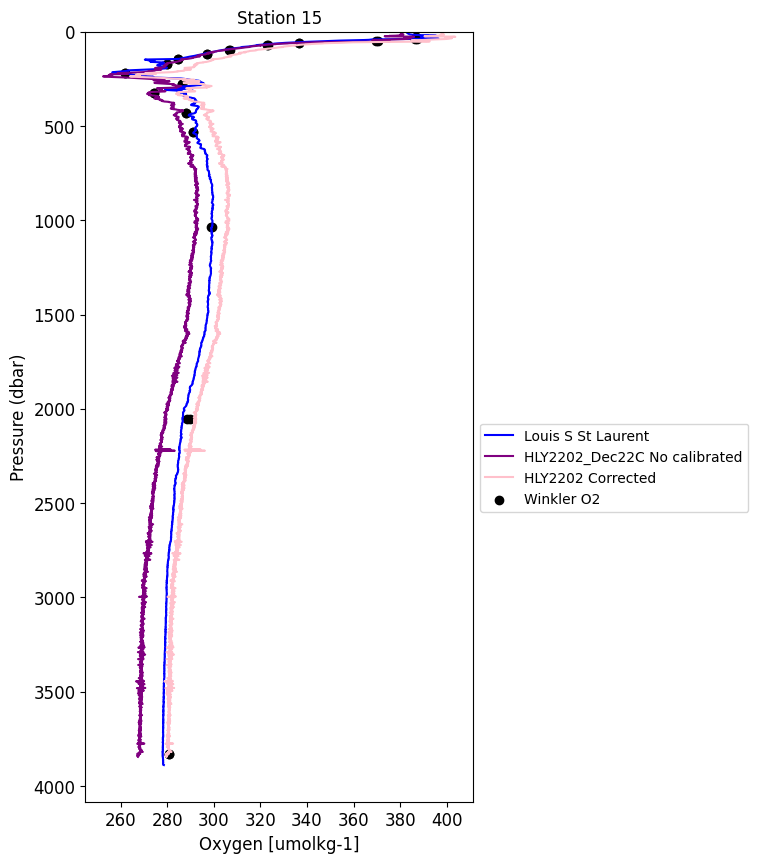

In [6]:
all_df['O2_correct']= all_df[16]*1.04575
station15  = all_df.loc[all_df['Cast'] == 15]

compare = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/d2022-045-0022.cnv', encoding="ISO-8859-1", delim_whitespace=True, skiprows=569, header=None)
compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
compare['sigma-den'] = compare['density-rho'] - 1000
oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)
# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(oxy,compare[1],color='blue', markersize=0.5, label= 'Louis S St Laurent')
plt.plot(station15[16],station15[0],color='purple', markersize=0.1, label= 'HLY2202_Dec22C No calibrated')
plt.plot(station15['O2_correct'],station15[0],color='pink', markersize=0.1, label= 'HLY2202 Corrected')
#plt.plot(station15['CFO2_above500'],station15[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station15['CFO2_below500'],station15[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
station15_W  = merged_df.loc[merged_df['Cast_x'] == 15]
plt.scatter(station15_W['Winkler umol/kg'],station15_W['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Station 15')

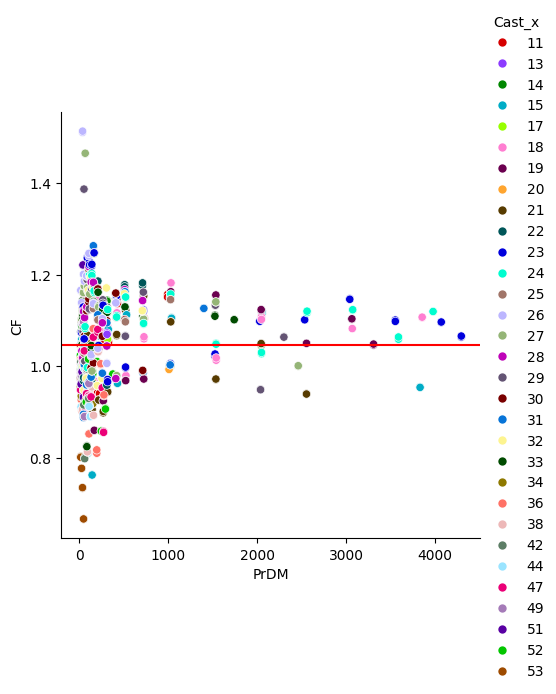

In [16]:
#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=31)

sns.relplot(x='PrDM',
            y='CF',
            data=merged_df,
            kind='scatter',
            legend='full', hue='Cast_x', palette=palette)

plt.axhline(y=1.04575, color='r', linestyle='-')

plt.show()

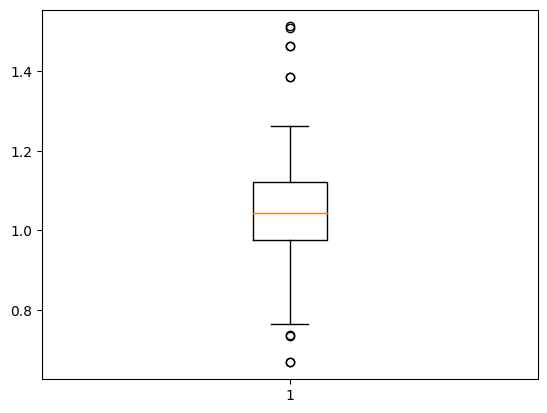

In [8]:
plt.boxplot(merged_df["CF"])
plt.show()

In [31]:
print(merged_df['CF'].quantile(0.10))
print(merged_df['CF'].quantile(0.90))

0.9295786490096886
1.1670104139407624


In [33]:
quantile = merged_df.loc[(merged_df['CF'] >= 0.9296) & (merged_df['CF'] <= 1.1670)]
quantile['CF'].mean()

1.0518390443898902

In [9]:
from scipy import stats
stddev_3 = merged_df[np.abs(stats.zscore(merged_df['CF'])) < 3]

from scipy import stats
stddev_2 = merged_df[np.abs(stats.zscore(merged_df['CF'])) < 2]

In [10]:
stddev_2['CF'].mean(), stddev_3['CF'].mean()

(1.048985812245669, 1.0443426882323057)

Text(0.5, 1.0, 'Station 15')

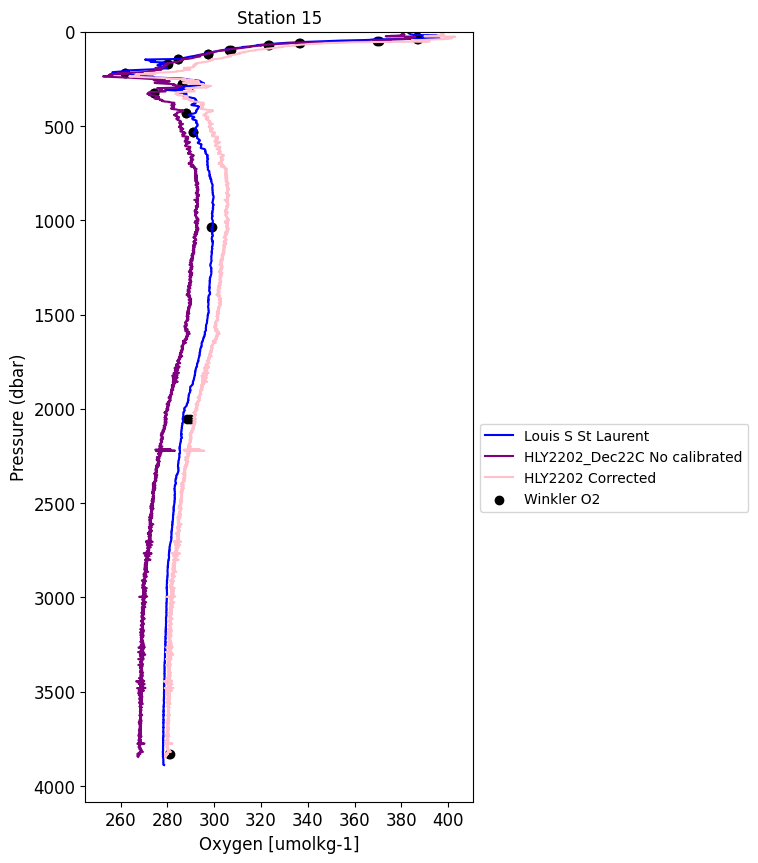

In [11]:
all_df['O2_stddev3']= all_df[16]*1.0443
station15  = all_df.loc[all_df['Cast'] == 15]

compare = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/d2022-045-0022.cnv', encoding="ISO-8859-1", delim_whitespace=True, skiprows=569, header=None)
compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
compare['sigma-den'] = compare['density-rho'] - 1000
oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)
# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(oxy,compare[1],color='blue', markersize=0.5, label= 'Louis S St Laurent')
plt.plot(station15[16],station15[0],color='purple', markersize=0.1, label= 'HLY2202_Dec22C No calibrated')
plt.plot(station15['O2_stddev3'],station15[0],color='pink', markersize=0.1, label= 'HLY2202 Corrected')
#plt.plot(station15['CFO2_above500'],station15[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station15['CFO2_below500'],station15[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
station15_W  = merged_df.loc[merged_df['Cast_x'] == 15]
plt.scatter(station15_W['Winkler umol/kg'],station15_W['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Station 15')

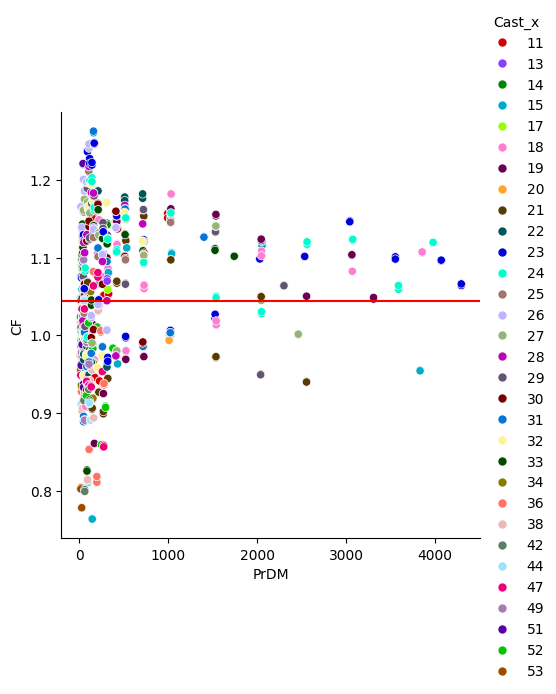

In [17]:
#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=31)

sns.relplot(x='PrDM',
            y='CF',
            data=stddev_3,
            kind='scatter',
            legend='full', hue='Cast_x', palette=palette)

plt.axhline(y=1.0443, color='r', linestyle='-')

plt.show()

Text(0.5, 1.0, 'North Pole')

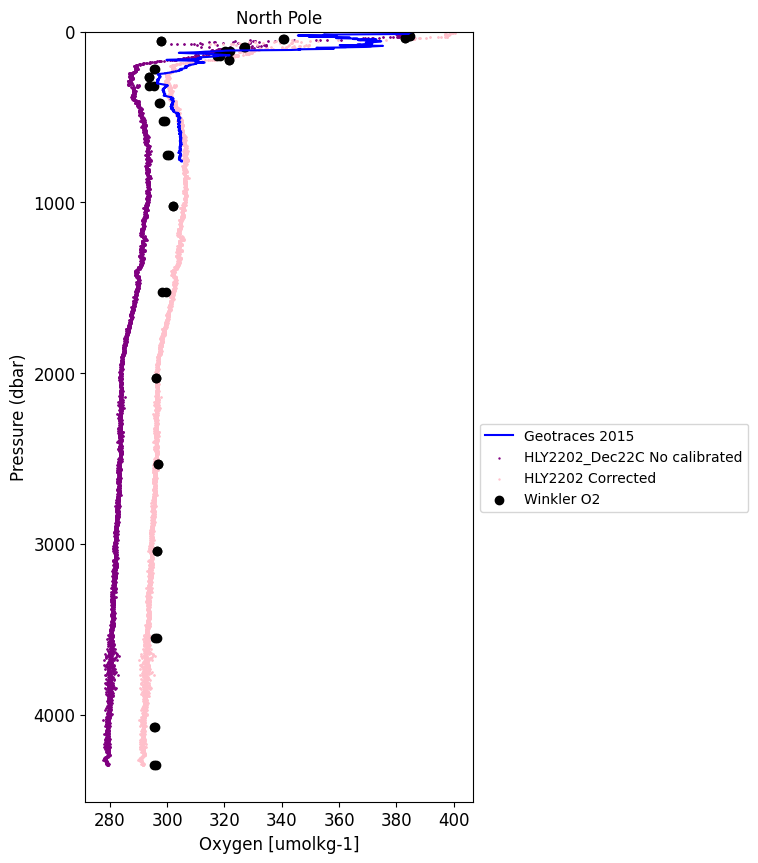

In [13]:
#Selecting only CTD North Pole Cast
station23  = all_df.loc[all_df['Cast'] == 23]
import xarray as xr
geo_lat90 = xr.open_dataset('/Users/mariacristinaalvarez/Documents/NorthPoleO2/Geotraces2015/East/33HQ20150809_00032_00004_ctd.nc')
#Calculate SA, CT #Can't calculate, file does not contain density, latitude and longitude t caculate TEOS-10
#compare['SA'] = gsw.SA_from_SP(compare[4], compare[1],compare[20],compare[19]) 
#compare['CT'] = gsw.conversions.CT_from_pt(compare['SA'],compare[20]) #conservative temperature ITS-90
#Calculate in-situ density and sigma theta

#Will use EOS-80 for this purposes
#compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
#compare['sigma-den'] = compare['density-rho'] - 1000

#oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)

#Selecting Winkler values from station 15
#merged_sigma['Cast'] = pd.to_numeric(merged_sigma['Cast'])
Winkler_S23 = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/HEALY2202_S21C23.csv')

# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(geo_lat90.oxygen,geo_lat90.pressure,color='blue', markersize=0.5, label= 'Geotraces 2015')
plt.scatter(station23[16],station23[0],color='purple', s= 0.5,label= 'HLY2202_Dec22C No calibrated')
plt.scatter(station23['O2_stddev3'],station23[0],color='pink', s= 0.5,label= 'HLY2202 Corrected')
#plt.plot(station23['CFO2_above500'],station23[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station23['CFO2_below500'],station23[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
plt.scatter(Winkler_S23['Winkler umol/kg'],Winkler_S23['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('North Pole')

In [38]:
all_df['O2_d2']= all_df[16]*1.0402
station15  = all_df.loc[all_df['Cast'] == 15]

compare = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/d2022-045-0022.cnv', encoding="ISO-8859-1", delim_whitespace=True, skiprows=569, header=None)
compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
compare['sigma-den'] = compare['density-rho'] - 1000
oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)
# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(oxy,compare[1],color='blue', markersize=0.5, label= 'Louis S St Laurent')
plt.plot(station15[16],station15[0],color='purple', markersize=0.1, label= 'HLY2202_Dec22C No calibrated')
plt.plot(station15['O2_stddev3'],station15[0],color='pink', markersize=0.1, label= 'HLY2202 Corrected')
#plt.plot(station15['CFO2_above500'],station15[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station15['CFO2_below500'],station15[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
station15_W  = merged_df.loc[merged_df['Cast_x'] == 15]
plt.scatter(station15_W['Winkler umol/kg'],station15_W['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Station 15')

257.0